In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
import yfinance as yf

# Define the ticker symbol for the S&P 500 index
ticker_symbol = "^DJI"

# Define the desired date range for the historical data
start_date = "2000-01-01"
end_date = "2023-07-01"

# Download the historical data using yfinance
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Print the downloaded data
print(data)

[*********************100%***********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2000-01-03  11501.849609  11522.009766  11305.690430  11357.509766   
2000-01-04  11349.750000  11350.059570  10986.450195  10997.929688   
2000-01-05  10989.370117  11215.099609  10938.669922  11122.650391   
2000-01-06  11113.370117  11313.450195  11098.450195  11253.259766   
2000-01-07  11247.059570  11528.139648  11239.919922  11522.559570   
...                  ...           ...           ...           ...   
2023-06-26  33730.789062  33819.488281  33610.320312  33714.710938   
2023-06-27  33739.031250  33975.648438  33730.390625  33926.738281   
2023-06-28  33881.378906  33903.761719  33755.921875  33852.660156   
2023-06-29  33854.570312  34147.679688  33828.628906  34122.421875   
2023-06-30  34269.921875  34467.351562  34269.921875  34407.601562   

               Adj C

Preprocess the data

In [ ]:
data = data.loc[start_date:end_date]

# Extract the 'Close' prices for training
close_prices = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

Split the data into training and testing sets

In [ ]:
# Define the training and testing set sizes
train_size = int(len(scaled_close_prices) * 0.8)
test_size = len(scaled_close_prices) - train_size

# Split the data into training and testing sets
train_data = scaled_close_prices[:train_size, :]
test_data = scaled_close_prices[train_size:, :]

Create the LSTM model

In [ ]:
# Define the number of previous time steps to consider for each prediction
n_steps = 60

# Create the training data by sliding the window of previous time steps
X_train, y_train = [], []
for i in range(n_steps, train_size):
    X_train.append(train_data[i-n_steps:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data to fit the LSTM model input shape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


Train the LSTM model

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
146/146 [==============================] - 16s 78ms/step - loss: 0.0022
Epoch 2/10
146/146 [==============================] - 11s 78ms/step - loss: 9.7163e-05
Epoch 3/10
146/146 [==============================] - 12s 79ms/step - loss: 9.3681e-05
Epoch 4/10
146/146 [==============================] - 11s 79ms/step - loss: 9.3759e-05
Epoch 5/10
146/146 [==============================] - 12s 79ms/step - loss: 9.2508e-05
Epoch 6/10
146/146 [==============================] - 11s 72ms/step - loss: 8.5629e-05
Epoch 7/10
146/146 [==============================] - 11s 78ms/step - loss: 8.3558e-05
Epoch 8/10
146/146 [==============================] - 12s 79ms/step - loss: 8.1829e-05
Epoch 9/10
146/146 [==============================] - 11s 79ms/step - loss: 7.4332e-05
Epoch 10/10
146/146 [==============================] - 11s 79ms/step - loss: 7.5168e-05


The reported loss value of `6.9963e-05` means that, on average, the squared difference between the predicted and actual values is very small.  A lower loss value suggests that the model has learned to make more accurate predictions during the training process.

Make predictions on the test data

In [ ]:
# Create the test data by sliding the window of previous time steps
X_test, y_test = [], []
for i in range(n_steps, test_size):
    X_test.append(test_data[i-n_steps:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the input data to fit the LSTM model input shape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predicted values
predictions = scaler.inverse_transform(predictions)


36/36 [==============================] - 2s 21ms/step


In [ ]:
# Create a dataframe for the predicted values
predictions_df = pd.DataFrame(predictions, columns=['Predicted'], index=data.index[train_size+n_steps:train_size+n_steps+test_size])

# Create a dataframe for the actual values
actual_df = pd.DataFrame(data['Close'].values[train_size+n_steps:train_size+n_steps+test_size], columns=['Actual'], index=data.index[train_size+n_steps:train_size+n_steps+test_size])

# Concatenate the predicted and actual values dataframes
result_df = pd.concat([predictions_df, actual_df], axis=1)


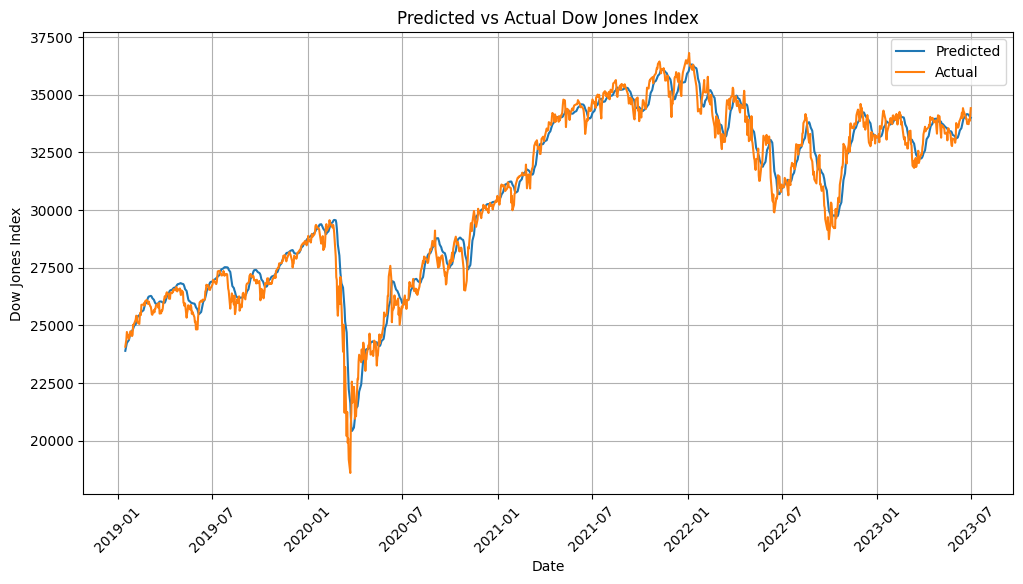

In [ ]:
# Plotting the predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(result_df.index, result_df['Predicted'], label='Predicted')
plt.plot(result_df.index, result_df['Actual'], label='Actual')
plt.xlabel('Date')
plt.ylabel('Dow Jones Index')
plt.title('Predicted vs Actual Dow Jones Index')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
# Extract the close prices for the entire dataset
close_prices_full = data['Close'].values.reshape(-1, 1)

# Normalize the full data
scaled_close_prices_full = scaler.transform(close_prices_full)

# Create the input data for forecasting by including the last n_steps values from the full data
X_forecast = scaled_close_prices_full[-n_steps:]

# Reshape the input data to fit the LSTM model input shape
X_forecast = np.reshape(X_forecast, (1, n_steps, 1))


In [ ]:
X_forecast

array([[[0.89035885],
        [0.89044381],
        [0.89378999],
        [0.89703829],
        [0.89577264],
        [0.90843904],
        [0.90370481],
        [0.90703381],
        [0.90668506],
        [0.90405331],
        [0.90040435],
        [0.90114279],
        [0.90333888],
        [0.89194911],
        [0.88438093],
        [0.90171131],
        [0.91070227],
        [0.90916651],
        [0.89702977],
        [0.88809523],
        [0.87862497],
        [0.89669418],
        [0.89485343],
        [0.89297317],
        [0.89196563],
        [0.88463349],
        [0.88433961],
        [0.88592561],
        [0.87480389],
        [0.88831112],
        [0.89211709],
        [0.8885048 ],
        [0.88387542],
        [0.87623752],
        [0.86778899],
        [0.86662309],
        [0.87748793],
        [0.87581671],
        [0.87137042],
        [0.87643778],
        [0.89961567],
        [0.8930079 ],
        [0.8933524 ],
        [0.89638481],
        [0.90195754],
        [0

In [ ]:
# Initialize an empty list to store the forecasted values
forecast_predictions = []

# Define the number of forecast steps
n_forecast_steps = 10

# Reshape the input data to fit the LSTM model input shape
X_forecast = np.reshape(X_forecast, (1, n_steps, 1))

# Generate multiple predictions for the forecast period
for _ in range(n_forecast_steps):
    # Make a prediction for the next timestep
    forecast = model.predict(X_forecast)

    # Append the forecasted value to the list
    forecast_predictions.append(forecast[0, 0])

    # Update the input sequence by shifting it and adding the new forecasted value at the end
    X_forecast = np.roll(X_forecast, -1, axis=1)
    X_forecast[0, -1, 0] = forecast

    # Reshape the input data for the next prediction
    X_forecast = np.reshape(X_forecast, (1, n_steps, 1))

# Inverse transform the forecasted values
forecast_predictions = scaler.inverse_transform(np.array(forecast_predictions).reshape(-1, 1))

# Create the forecasted date range
forecast_dates = pd.date_range(start='2023-07-01', periods=n_forecast_steps, freq='D')

# Create a dataframe for the forecasted values
forecast_df = pd.DataFrame(forecast_predictions, columns=['Forecast'], index=forecast_dates)


1/1 [==============================] - 0s 32ms/step


In [ ]:
forecast_df

,Forecast
2023-07-01,34014.398438
2023-07-02,34029.480469
2023-07-03,34041.503906
2023-07-04,34051.089844
2023-07-05,34058.820312
2023-07-06,34065.179688
2023-07-07,34070.597656
2023-07-08,34075.363281
2023-07-09,34079.691406
2023-07-10,34083.734375


In [ ]:
# Define the number of forecast steps
n_forecast_steps = 10

# Initialize an empty list to store the forecasted values
forecast_predictions = []

# Reshape the input data to fit the LSTM model input shape
X_forecast = np.reshape(X_forecast, (1, n_steps, 1))

# Generate multiple predictions for the forecast period
for _ in range(n_forecast_steps):
    # Make a prediction for the next timestep
    forecast = model.predict(X_forecast)

    # Append the forecasted value to the list
    forecast_predictions.append(forecast[0, 0])

    # Update the input sequence by shifting it and adding the new forecasted value at the end
    X_forecast = np.roll(X_forecast, -1, axis=1)
    X_forecast[0, -1, 0] = forecast

    # Reshape the input data for the next prediction
    X_forecast = np.reshape(X_forecast, (1, n_steps, 1))

# Inverse transform the forecasted values
forecast_predictions = scaler.inverse_transform(np.array(forecast_predictions).reshape(-1, 1))

# Create the forecasted date range
forecast_dates = pd.date_range(start='2023-07-02', periods=n_forecast_steps, freq='D')

# Create a dataframe for the forecasted values
forecast_df = pd.DataFrame(forecast_predictions, columns=['Forecast'], index=forecast_dates)

# Print the forecasted values
print(forecast_df)


1/1 [==============================] - 0s 30ms/step
                Forecast
2023-07-02  34087.589844
2023-07-03  34091.332031
2023-07-04  34094.980469
2023-07-05  34098.570312
2023-07-06  34102.117188
2023-07-07  34105.621094
2023-07-08  34109.093750
2023-07-09  34112.531250
2023-07-10  34115.925781
2023-07-11  34119.292969


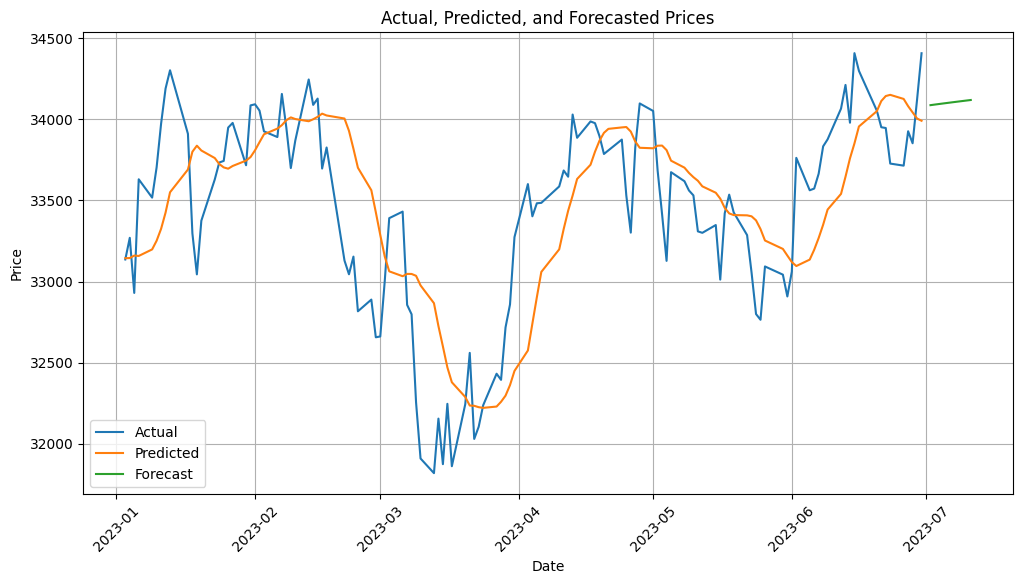

In [ ]:
# Define the start and end dates for the plot
plot_start_date = '2023-01-01'
plot_end_date = '2023-07-11'

# Filter the result dataframe for the desired date range
plot_data = result_df.loc[plot_start_date:plot_end_date]

# Filter the forecast dataframe for the desired date range
plot_forecast = forecast_df.loc[plot_start_date:plot_end_date]

# Plot the actual, predicted, and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(plot_data.index, plot_data['Actual'], label='Actual')
plt.plot(plot_data.index, plot_data['Predicted'], label='Predicted')
plt.plot(plot_forecast.index, plot_forecast['Forecast'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual, Predicted, and Forecasted Prices')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
